In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, silhouette_score

In [111]:
train = pd.read_csv('out.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    499 non-null    int64 
 1   ms            499 non-null    int64 
 2   start letter  499 non-null    object
 3   end letter    499 non-null    object
dtypes: int64(2), object(2)
memory usage: 15.7+ KB


In [112]:
train.head()

,Unnamed: 0,ms,start letter,end letter
0,0,119629,T,shift
1,1,208910,shift,h
2,2,352476,h,space
3,3,445039,space,space
4,4,524134,space,u


In [113]:
train = train.drop(['Unnamed: 0'], axis=1)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ms            499 non-null    int64 
 1   start letter  499 non-null    object
 2   end letter    499 non-null    object
dtypes: int64(1), object(2)
memory usage: 11.8+ KB


# Data Preprocessing
1. combine `start letter` and `end letter` to form `key_combo` column, then drop the 2 other columns
2. If there are multiple of the same `key_combo` values, average the `ms` values

In [114]:
train['key_combo'] = train['start letter'] + train['end letter']
train = train.drop(['start letter', 'end letter'], axis=1)

In [115]:
train.head()

,ms,key_combo
0,119629,Tshift
1,208910,shifth
2,352476,hspace
3,445039,spacespace
4,524134,spaceu


In [116]:
# Check if there are multiple of same key_combo values
train = train.groupby('key_combo').mean().reset_index()

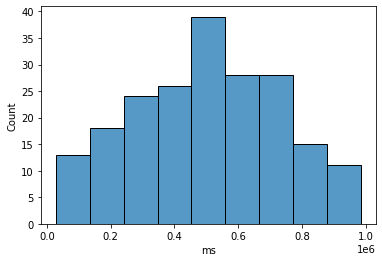

In [117]:
sns.histplot(train['ms'])
plt.show()

# Methods for prediction

## Method 1: Cluster Method
Compare the cluster of the new data point to the cluster of the training data points. If the cluster of the new data point is the same as the cluster of the training data points, then the new data point is classified as the same class as the training data points. If the cluster of the new data point is different from the cluster of the training data points, then the new data point is classified as a different class than the training data points.

Take the percentage of the correct classifications and set threshold to determine if the user should be authenticated or not.

### Training KMeans Model

In [118]:
# do KMeans on the ms column
kmeans_train = KMeans(n_clusters=3, random_state=42).fit(train[['ms']])
kmeans_train.cluster_centers_

array([[215151.45      ],
       [776620.56737288],
       [505307.31974024]])

In [119]:
verification = train.copy()
verification['cluster'] = kmeans_train.labels_

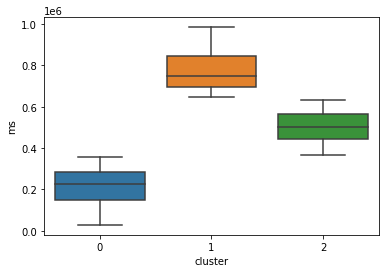

In [120]:
# boxplot of each cluster
sns.boxplot(x='cluster', y='ms', data=verification)
plt.show()

### Predicting on Test Data

In [121]:
# Using KMeans to cluster test data using predefined centroids
centroids = kmeans_train.cluster_centers_
kmeans_test = KMeans(n_clusters=3, random_state=42, init=centroids).fit(train[['ms']])

C:\Users\junnj\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1307: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params(X)


In [122]:
test_data = train.copy()
test_data['clusters'] = kmeans_test.labels_

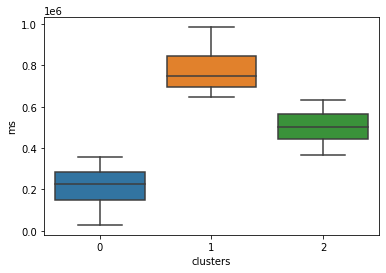

In [123]:
# boxplot of each cluster
sns.boxplot(x='clusters', y='ms', data=test_data)
plt.show()

In [124]:
# check if key_combo in test data exists in train data
test_data['key_combo'].isin(train['key_combo']).value_counts()

True    202
Name: key_combo, dtype: int64

## Method 2: Mean-Squared Error Method
Take the Average Mean-Squared Error of the entire test dataset when compared to the train dataset. Then, set a threshold for the Mean-Squared Error to determine if the user should be authenticated or not.